In [3]:
# load all libraries reqd for the project
#Steps for the project
#1.Camera calibration
#2.Distortion correction
#3.Color/gradient threshold
#4.Perspective transform
#5.Detect lane lines
#6.Determine the lane curvature
import numpy as np
import cv2
import scipy.ndimage as snd
import matplotlib.pyplot as plt
import glob
%matplotlib inline

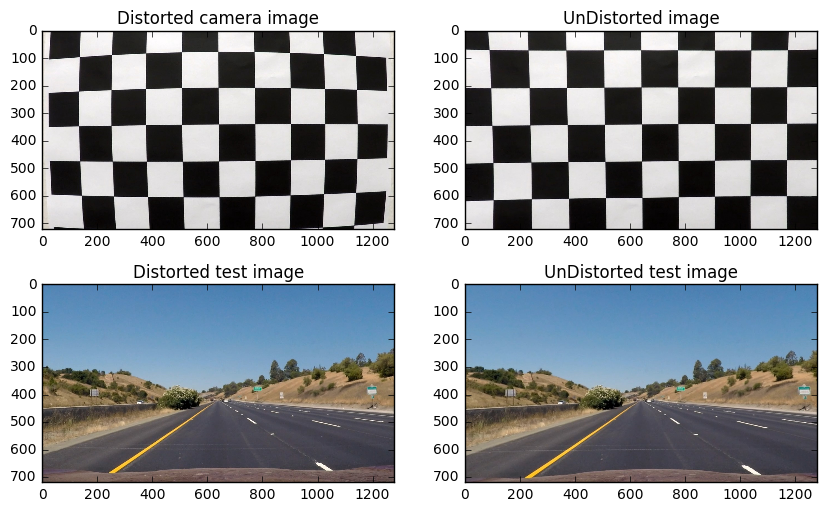

In [7]:
# Calibrate Camera
nx, ny = 9, 6
objp = np.zeros((nx*ny,3),np.float32) # 3d real world space
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
objpts = [] # 3d real world space
imgpts = [] # 2d corners
inames = glob.glob('camera_cal/calibration*.jpg')
#plt.imshow(snd.imread(inames[0]))
for iimage in range(len(inames)):
    #plt.imshow(snd.imread(inames[5]))
    img = snd.imread(inames[iimage])
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #plt.imshow(gray)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    #print(ret)
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)
        #iimg = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(iimg)

# return camera matrix (mtx), distortion coefficients (dist)
retc, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts,imgpts,img.shape[0:2],None,None)

# check camera matrix undistortion results
img = snd.imread(inames[0])
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title('Distorted camera image')

plt.subplot(2, 2, 2)
undistort = cv2.undistort(img,mtx,dist,None,mtx)
plt.imshow(undistort)
plt.title("UnDistorted image")

img2 = snd.imread('./test_images/straight_lines1.jpg')
plt.subplot(2, 2, 3)
plt.imshow(img2)
plt.title('Distorted test image')

plt.subplot(2, 2, 4)
undistort = cv2.undistort(img2,mtx,dist,None,mtx)
plt.imshow(undistort)
plt.title("UnDistorted test image")

In [8]:
# define all sobel and color space functions for edge detection and combine them to get results like canny edge detection
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= np.min(mag_thresh)) & (scaled_sobel <= np.max(mag_thresh))] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return mag_binary
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dir_gradient)
    dir_binary[(dir_gradient >= np.min(thresh)) & (dir_gradient <= np.max(thresh))] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return dir_binary

def color_threshold(img, thresh = (0,255), hlschannel = 's'):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if hlschannel == 's':
        color = 2 # saturation
    elif hlschannel == 'l':
        color = 1 # lightness
    else:
        color = 0 # hue
        
    c_channel = hls[:,:,color]
    c_binary = np.zeros_like(c_channel)
    c_binary[(c_channel >= np.min(thresh)) & (c_channel <= np.max(thresh))] = 1
    
    return c_binary

In [24]:
def find_edges(undist):
    gradx = abs_sobel_thresh(undist, orient = 'x', thresh_min=30, thresh_max=100) # 20,100
    mag_binary = mag_thresh(undist, sobel_kernel=5, mag_thresh=(30, 100)) # 30,100
    dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3)) # 0.7,1.3
    s_binary   = color_threshold(undist,thresh=(170,255), hlschannel = 's') #90,255 # yellow line
    l_binary   = color_threshold(undist,thresh=(220,255), hlschannel = 'l') #220,255 # white line 
    gradx = abs_sobel_thresh(undist, orient = 'x', thresh_min=30, thresh_max=100) # 20,100
    #shadow_binary = color_threshold(undist,thresh=(0,25), hlschannel = 'l') #0,25 # white line 
    combined = np.zeros_like(dir_binary)
    # including grady makes it difficult to get far lines
    combined[(gradx == 1) | ((s_binary == 1) | (l_binary == 1))] = 1
    return combined

def lane_lines_source_pts(edges_image, furthestview_factor = 1.6):
    # inspiration from project P1 , added furthestview_factor to try to run pipeline for harder challenge video
    # mask the image
    mask = np.zeros_like(edges_image)   
    ignore_mask_color = 255
    imshape = edges_image.shape
    # vertical axis minimum and maximum horizon for line extrapolation
    ymax   = imshape[0]
    ymin   = np.int(np.round(ymax/furthestview_factor))
    vertices = np.array([[(0,ymax-50),(imshape[1]/2.6, ymin),\
                                                (imshape[1]/1.45, ymin),(imshape[1],ymax-50)]], dtype=np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    edges_roi = cv2.bitwise_and(edges_image*255, mask)
    
    # generate hough lines
    threshold, min_line_len, max_line_gap = 45, 15, 5 # started with 15,20,5 as P1 
    lines = cv2.HoughLinesP(np.uint8(edges_roi), 1, np.pi/180, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*edges_image.shape, 3), dtype=np.uint8)
    
    # Find lines of interest and combine them to get edges of line
    rFit = []
    lFit = []
    lLength = []
    rLength = []
    offset = 100
    try: # issue found in challenge video then no houghlines were seen with my thresholds and had to handle for it
        for line in lines:
            for x1,y1,x2,y2 in line:
                slopeLine = ((y2-y1)/(x2-x1))
                if (slopeLine > 0.5 and slopeLine < 10 and x1 > imshape[0]/2-offset and x2 > imshape[0]/2-offset): # right lane
                    #print('{}-x1 {}-y1 {}-x2 {}-y2'.format(x1,y1,x2,y2))
                    rFit.append(np.polyfit((x1,x2), (y1,y2),1))
                    rLength.append(np.sqrt(np.square(x2-x1)+np.square(y2-y1)))
                elif (slopeLine < -0.5 and slopeLine > -10 and x1 < imshape[0]/2+offset and x2 < imshape[0]/2+offset): # left lane 
                    lFit.append(np.polyfit((x1,x2),(y1,y2),1))
                    lLength.append(np.sqrt(np.square(x2-x1)+np.square(y2-y1)))
        lFit = np.asarray(lFit)
        rFit = np.asarray(rFit)
        lLength = np.asarray(lLength)
        rLength = np.asarray(rLength)
        lSort = np.zeros((lLength.size,3))
        rSort = np.zeros((rLength.size,3))
    except TypeError:
        lFit, rFit = np.array([]), np.array([])
    
    # sort according to line length
    if (lFit.shape[0] != 0 and rFit.shape[0] != 0):
        lSort[:,1:] = lFit
        lSort[:,0] = lLength
        lSort = np.array(lSort)
        lSort = lSort[np.argsort(lSort[:,0])]
        rSort[:,1:] = rFit
        rSort[:,0] = rLength
        rSort = np.array(rSort)
        rSort = rSort[np.argsort(rSort[:,0])]

        # average with weighting according to line length, bigger line length - more the weight
        lAvg = [np.average(lSort[:,1],weights=np.arange(1,(lSort.shape)[0]+1,1)), \
                np.average(lSort[:,2],weights=np.arange(1,(lSort.shape)[0]+1,1))]
        rAvg = [np.average(rSort[:,1],weights=np.arange(1,(rSort.shape)[0]+1,1)), \
                np.average(rSort[:,2],weights=np.arange(1,(rSort.shape)[0]+1,1))]

        x2lAvg = np.int((ymin-lAvg[1])/lAvg[0])
        x1lAvg = np.int((ymax-lAvg[1])/lAvg[0])
        x2rAvg = np.int((ymin-rAvg[1])/rAvg[0])
        x1rAvg = np.int((ymax-rAvg[1])/rAvg[0])
        
    else:
        x1lAvg, x2lAvg, x2rAvg, x1rAvg = 200, 550, 750, 1100 

    
    corners = np.float32([[x1lAvg, ymax], [x2lAvg, ymin],[x2rAvg, ymin],[x1rAvg, ymax]])
    return corners

In [10]:
def corners_unwarp(img, mtx, dist,furthestview_factor):
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert to canny edge style white edges for finding lane lines
    combined = find_edges(undist)
    
    #gray = combined
    # 3) Find the corners
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    # get current image src points for unwarping -- done automatically
    src = lane_lines_source_pts(combined,furthestview_factor)
    #offset = 100 # offset for dst points
    img_size = (combined.shape[1], combined.shape[0])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[src[0,0], img_size[1]], 
                     [src[0,0], 0], 
                     [src[3,0], 0],
                     [src[3,0], img_size[1]]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    #delete the next two lines
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv, undist, combined, src, dst

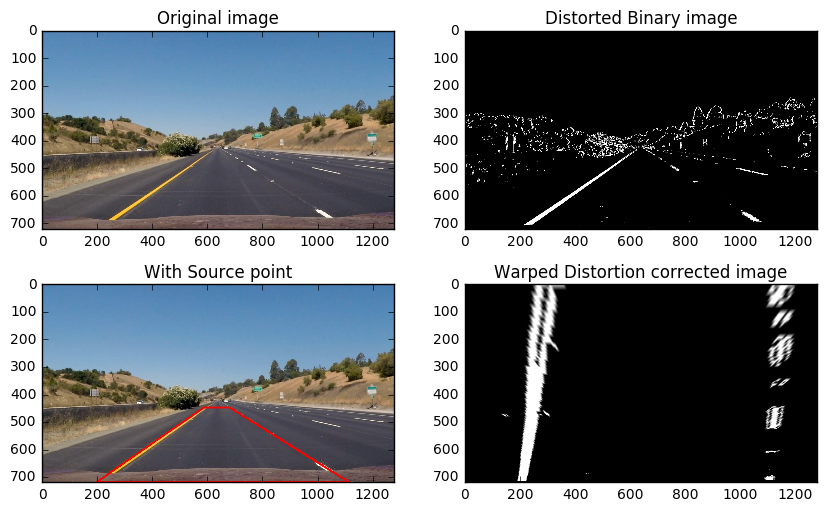

[[  198.   720.]
 [  586.   450.]
 [  680.   450.]
 [ 1113.   720.]]


In [11]:
onames = glob.glob('test_images/*.jpg')
image = snd.imread(onames[0])
lanes, perspective_M, Minv, undist, binary_combined, src, dst = corners_unwarp(image, mtx, dist,1.6) # 1.6 is how far you are seeing ,ymin

plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Original image')

plt.subplot(2, 2, 3)
points = np.array(src,dtype = np.int32)
plt.imshow(cv2.polylines(image,[points],1,(255,0,0),thickness = 5))
plt.title('With Source point')

plt.subplot(2, 2, 2)
plt.imshow(binary_combined,cmap = 'gray')
plt.title('Distorted Binary image')

plt.subplot(2, 2, 4)
plt.imshow(lanes,cmap = 'gray')
plt.title('Warped Distortion corrected image')
plt.show()
print(src)

In [72]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output
def find_window_centroids(warped, window_width = 50, window_height = 80, margin = 100):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2-margin)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2)+margin:], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2+margin)
    
    # modification to again cater for challenge video as right lane always going to center at around 9secs
    print(r_center)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    if sum(conv_signal[l_min_index:l_max_index])>0: # if no next layer convolution found use previous
	        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    if sum(conv_signal[r_min_index:r_max_index])>0: # if no next layer convolution found use previous
	        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center)) 
    return window_centroids

def overlay_window_centroids_with_image(window_centroids,lanes,window_width, window_height):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(lanes)
        r_points = np.zeros_like(lanes)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,lanes,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,lanes,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((lanes,lanes,lanes)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((lanes,lanes,lanes)),np.uint8)
        
    return output

def filtered_and_fit_laneline(binary_combined,window_centroids,y_centroids):
    # draw the lines
    window_centroids_array = np.asarray(window_centroids)
    leftx    = np.flipud(window_centroids_array[:,0]) # so that the x starts from top of image
    rightx   = np.flipud(window_centroids_array[:,1]) # so that the x starts from top of image
    
    # reject outliers
    y_mu, y_sig = np.mean(y_centroids), np.std(y_centroids)
    xl_mu, xl_sig = np.mean(leftx), np.std(leftx)
    xr_mu, xr_sig = np.mean(rightx), np.std(rightx)
    
    if (xl_sig>0 and xr_sig > 0): 
        leftx_f, lefty_f = zip(*[(x, y) for (x,y) in zip(leftx, y_centroids) \
                                if abs(x - xl_mu) < 2*xl_sig and abs(y - y_mu) < 2*y_sig])
        rightx_f, righty_f = zip(*[(x, y) for (x,y) in zip(rightx, y_centroids) \
                                if abs(x - xr_mu) < 2*xr_sig and abs(y - y_mu) < 2*y_sig])
    else: # if potentially exactly straight line found then use non-filtered values
        leftx_f, lefty_f = leftx, y_centroids
        rightx_f, righty_f = rightx, y_centroids
    ''' ## not needed as already filtered out in 'find_window_centroids' function ##
    # reject outlier - method 2
    dl = [np.diff(leftx_f)]
    dl = np.append(dl,0)
    dr = [np.diff(rightx_f)]
    dr = np.append(dr,0)
    while (np.logical_or((dr>=100),(dr<=-100))).any() or (np.logical_or((dl>=100),(dl<=-100))).any():
        flag = np.ones_like(dr,dtype=bool)
        flag[np.logical_or((dr>=100),(dr<=-100))] = False
        rightx_f, righty_f = np.asarray(rightx_f)[flag], np.asarray(righty_f)[flag]
        flag = np.ones_like(dl,dtype = bool)
        flag[np.logical_or((dl>=100),(dl<=-100))] = False
        leftx_f, lefty_f = np.asarray(leftx_f)[flag], np.asarray(lefty_f)[flag]
        dl = [np.diff(leftx_f)]
        dl = np.append(dl,0)
        dr = [np.diff(rightx_f)]
        dr = np.append(dr,0)
    '''    
    # fit the line
    left_fit = np.polyfit(lefty_f,leftx_f,2)
    right_fit = np.polyfit(righty_f,rightx_f,2)
    #generate a line
    ploty = np.linspace(0, binary_combined.shape[0]-1, binary_combined.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

#get radius of curvature
def curverad_and_distance_tocentre(image,ploty,left_fitx,right_fitx):
    y_eval = np.max(ploty) # max value of y corresponding to bottom of image
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad) in pixels

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature in meters
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    # distance to center in meters
    screen_middel_pixel = image.shape[1]//2
    car_middle_pixel = int((left_fitx[-1] + right_fitx[-1])//2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    dist_to_center = xm_per_pix * screen_off_center #pixels_off_center (+ve, right and -ve left)
    
    return left_curverad, right_curverad, dist_to_center

# Create an image to draw the lines on
def image_with_laneline(undist,lanes,left_fitx,right_fitx,ploty,Minv,left_curverad,right_curverad,dist_to_center):
    warp_zero = np.zeros_like(lanes).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Draw lane markers
    pts = np.transpose(np.vstack([left_fitx, ploty])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (255,0,0), thickness=30)
    pts = np.transpose(np.vstack([right_fitx, ploty])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (0,0,255), thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
    #put text in result image
    if dist_to_center<0:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(abs(dist_to_center)), (100,80),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(dist_to_center), (100,80),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'Left Curvature is {:.0f}m'.format(left_curverad), (100,160),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'Right Curvature is {:.0f}m'.format(right_curverad), (100,240),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    
    return result

1118.0


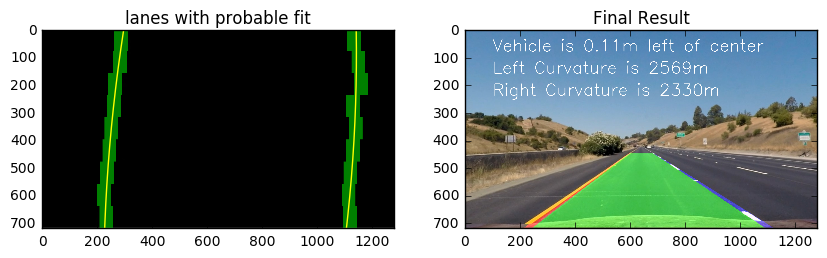

In [46]:
window_height = 80
window_centroids = find_window_centroids(lanes)
y_centroids = np.arange(window_height/2,lanes.shape[0],window_height)
ploty, left_fitx, right_fitx = filtered_and_fit_laneline(binary_combined,window_centroids,y_centroids)
left_curverad,right_curverad, dist_to_center = curverad_and_distance_tocentre(lanes,ploty,left_fitx,right_fitx)
result = image_with_laneline(undist,lanes,left_fitx,right_fitx,ploty,Minv,left_curverad,right_curverad,dist_to_center)

plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
output = overlay_window_centroids_with_image(window_centroids,lanes,50, window_height)
plt.imshow(output)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('lanes with probable fit')

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title('Final Result')
plt.show()

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
# Define a class to receive the characteristics of each line detection
import collections
from itertools import chain, repeat
from functools import reduce

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/900 # meters per pixel in x dimension

class Lane():
    def __init__(self, base_pt, img_size, cache_length):
        # was the line detected in the last iteration?
        self.detected = False  
        # x & y values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=cache_length)
        self.recent_yfitted = collections.deque(maxlen=cache_length)
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.insanity = 0.0 
                
        self.current_xfit = None
        #self.base_pt = base_pt
        
        self.yvals = np.linspace(0, img_size[0], 101)
        self.mask = np.ones(img_size, dtype=np.uint8)*255
        
        self.dropped_frames = 0
    
    def add_lane_pixels(self, x, y):
        # Use all pixels from previous detections for curve fit
        weights = np.ones(len(self.recent_xfitted))
        if len(weights) > 1:
            weights[0] = 0.8
            weights[1:] = 0.2/(len(weights) - 1)

            w_x = reduce(lambda a,b: a + b[0]*b[1], zip(weights, self.recent_xfitted), np.zeros(len(self.yvals)))
            w_y = reduce(lambda a,b: a + b[0]*b[1], zip(weights, self.recent_yfitted), np.zeros(len(self.yvals)))
        else:
            w_x, w_y = [], []
        x_hist = np.fromiter(chain(w_x, x), np.int32)
        y_hist = np.fromiter(chain(w_y, y), np.int32)

        try:
            p_lane = np.polyfit(y_hist, x_hist, 2)
            rad_curv = self.compute_rad_curv(x_hist, y_hist)
            self.detected = self.sanity_check_lane(rad_curv)
        except Exception as e:
            print(e)
            self.detected = False

        if self.detected and len(p_lane) == 3:
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]

            self.current_xfit = x_fit   # For drawing

            self.recent_xfitted.append(x_fit)
            self.recent_yfitted.append(self.yvals)

            self.radius_of_curvature = rad_curv
            self.current_fit = p_lane
            self.dropped_frames = 0
        else:
            # Sanity check failed
            # Use last fit if current one failed
            p_lane = self.current_fit
            rad_curv = self.radius_of_curvature
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]
            self.dropped_frames += 1
        
    @staticmethod
    def compute_rad_curv(xvals, yvals):
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        y_eval = np.max(yvals)
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
        return curverad
        
        
    def sanity_check_lane(self, R):
        # Checks new radius of curvature `R` against the radius stored in the object.
        # Return true if there is no prior data
        if self.radius_of_curvature is None:
            return True
        
        k = 1/R   # Curvature is a better measure to track
        R0 = self.radius_of_curvature
        k0 = 1/self.radius_of_curvature
        self.insanity = abs(R-R0)/R0
        return self.insanity <= 0.5  # Max change from frame to frame is 200%
      
    def use_previous_fits(self, warped, margin = 50):
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        line_inds = ((nonzerox > (self.current_fit[0]*(nonzeroy**2) + self.current_fit[1]*nonzeroy + self.current_fit[2] - margin)) \
                          & (nonzerox < (self.current_fit[0]*(nonzeroy**2) + self.current_fit[1]*nonzeroy + self.current_fit[2] + margin))) 
    
        # Again, extract left and right line pixel positions
        if sum(line_inds)>0:
            linex = nonzerox[line_inds]
            liney = nonzeroy[line_inds] 
            linefit = np.polyfit(liney, linex, 2)
        # Generate x and y values for plotting
            ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
            line_fitx = linefit[0]*ploty**2 + linefit[1]*ploty + linefit[2]
            self.add_lane_pixels(line_fitx,ploty)
        else:
            self.detected = False

In [17]:
def process_image(image, cam_mtx, cam_dist, furthestview_factor, cache_length=12):
    #global cam_mtx, cam_dist
    
    if process_image.cache is None:
                
        left_lane = Lane(int(image.shape[0]), image.shape[:2], cache_length=cache_length)
        right_lane = Lane(int(image.shape[0]), image.shape[:2], cache_length=cache_length)

        cache = {'cam_mtx': cam_mtx,
                 'cam_dist': cam_dist,
                 'warp_m': None,
                 'warp_minv': None,
                 'frame_ctr': 0,
                 'left': left_lane,
                 'right': right_lane,
                 'base_pts': None}
    else:
        cache = process_image.cache
    

    left_lane = cache['left']
    right_lane = cache['right']

    # Preprocess image and find edges using thresholding
    # furthestview_factor can be a constant (like 1.6) but for challenge videos or slow vehicle speeds it makes sense to reduce -- potential to automate this process
    _, perspective_M, Minv, undist, _, src, dst = corners_unwarp(image, cam_mtx, cam_dist,furthestview_factor)

    if ((left_lane.current_xfit is None or left_lane.dropped_frames >= 9) 
            or (right_lane.current_xfit is None or right_lane.dropped_frames >= 9)):
        # Detect from scratch
        warp_m, warp_minv = perspective_M, Minv
        cache['warp_m'], cache['warp_minv'] = warp_m, warp_minv # add to cache for next image
        left_lane.radius_of_curvature = None
        right_lane.radius_of_curvature = None
        left_lane.recent_xfitted.clear()
        left_lane.recent_yfitted.clear()
        right_lane.recent_xfitted.clear()
        right_lane.recent_yfitted.clear()
        warp_img = cv2.warpPerspective(undist, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        warp_edges = find_edges(warp_img) # all sobel, colorspace operator again
        window_centroids = find_window_centroids(warp_edges)
        y_centroids = np.arange(window_height/2,lanes.shape[0],window_height)
        ploty, left_fitx, right_fitx = filtered_and_fit_laneline(binary_combined,window_centroids,y_centroids)
        left_lane.add_lane_pixels(left_fitx, ploty)
        right_lane.add_lane_pixels(right_fitx, ploty)
    else:
        # Detect using previous image
        warp_m, warp_minv =  cache['warp_m'], cache['warp_minv']
        warp_img = cv2.warpPerspective(undist, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        warp_edges = find_edges(warp_img) # all sobel, colorspace operator again
        left_lane.use_previous_fits(warp_edges)
        right_lane.use_previous_fits(warp_edges)

    cache['frame_ctr'] = cache['frame_ctr'] + 1
    process_image.cache = cache
    
    yvals = right_lane.yvals
    left_fitx = left_lane.current_xfit
    right_fitx = right_lane.current_xfit

    left_r = left_lane.radius_of_curvature
    right_r = right_lane.radius_of_curvature
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = image.shape[1]//2
    
    dx = (veh_pos - middle)*xm_per_pix # Positive if on right, Negative on left
    
    # final output with text on video or images
    result = image_with_laneline(undist,warp_edges,left_fitx,right_fitx,yvals,warp_minv,left_r,right_r,dx)
    
    is_tracking = left_lane.detected or right_lane.detected
    cv2.putText(result,'Tracking Locked' if is_tracking else 'Tracking Lost',(100,400),
            cv2.FONT_ITALIC, 1,(0,255,0) if is_tracking else (255,0,0), 3,cv2.LINE_AA)
      
    cache['left'] = left_lane
    cache['right'] = right_lane

    return result

def clear_cache():
    process_image.cache = None

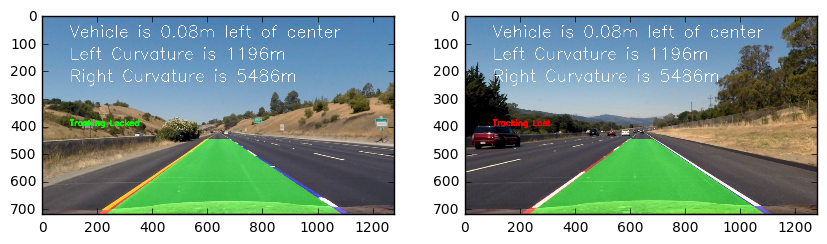

In [19]:
process_image.clear_cache = clear_cache
clear_cache()
image = snd.imread(onames[0])
image2 = snd.imread(onames[1])
#%time process_image(image)
#%time process_image(image)
out = process_image(image,mtx,dist,1.6)
out2 = process_image(image2,mtx,dist,1.6)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(out)
plt.subplot(1,2,2)
plt.imshow(out2)


In [27]:
clear_cache()
output = 'result_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip((0,40),(0,43))
output_clip = clip1.fl_image(lambda image: process_image(image,mtx,dist,1.6)) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4


100%|█████████▉| 1260/1261 [14:50<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_video.mp4 

Wall time: 14min 52s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
clear_cache()
output2 = 'result_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4").subclip((0,8),(0,9))
output_clip = clip1.fl_image(lambda image: process_image(image,mtx,dist,1.4)) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output2, audio=False)

In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

In [ ]:
clear_cache()
output3 = 'result_harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
#clip1 = VideoFileClip("harder_challenge_video.mp4").subclip((0,0),(0,10))
output_clip = clip1.fl_image(lambda image: process_image(image,mtx,dist,1.3)) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output3, audio=False)

In [82]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))